# Flight Price Forecast - Model Evaluation

This notebook provides comprehensive evaluation of trained models:

- Assess model performance using multiple regression metrics
- Create confusion matrices and performance visualizations
- Detect overfitting and underfitting issues
- Compare model performance across different scenarios
- Generate detailed evaluation reports

**Prerequisites**: Complete model training in `04_model_training.ipynb`.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Model evaluation metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             mean_absolute_percentage_error, explained_variance_score)
from sklearn.model_selection import validation_curve, learning_curve, cross_validate
from sklearn.inspection import permutation_importance

# Statistical analysis
from scipy import stats
import joblib

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully for Model Evaluation!")

Libraries imported successfully for Model Evaluation!


## 2. Load Trained Models and Data


In [2]:
# Load trained model and artifacts
try:
    # Load the best model
    best_model = joblib.load('../models/best_model.pkl')
    scaler = joblib.load('../models/scaler.pkl')

    # Load feature metadata
    import json
    with open('../models/feature_columns.json', 'r') as f:
        feature_cols = json.load(f)

    # Load performance data
    with open('../models/model_performance.json', 'r') as f:
        performance_data = json.load(f)

    print("✓ Trained model and artifacts loaded successfully!")
    print(f"Best model: {performance_data['best_model_name']}")
    print(f"Features: {len(feature_cols)}")
    print(f"Training date: {performance_data['training_date']}")

    model_loaded = True

except FileNotFoundError as e:
    print(f"⚠ Model files not found: {e}")
    print("Please run the model training notebook (04_model_training.ipynb) first.")
    model_loaded = False

# Load test data (try multiple sources)
try:
    # Try to load processed data with features
    df = pd.read_csv('../data/features_selected.csv')
    print("✓ Feature-selected data loaded")
except FileNotFoundError:
    try:
        df = pd.read_csv('../data/cleaned_data.csv')
        print("✓ Cleaned data loaded")
    except FileNotFoundError:
        df = pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv')
        df = df.dropna()
        print("✓ Original dataset loaded with basic cleaning")

print(f"Dataset shape: {df.shape}")
df.head()

✓ Trained model and artifacts loaded successfully!
Best model: LightGBM
Features: 8
Training date: 2025-11-28T19:01:49.934633
✓ Feature-selected data loaded
Dataset shape: (176982, 9)


,fare_lg,lf_ms,distance_cat_encoded,fare_low,fare_spread,nsmiles,large_ms,combined_ms,fare
0,247.69,0.20,0,166.99,80.70,1887,0.38,0.58,226.59
1,292.60,0.24,0,248.27,44.33,1678,0.73,0.97,280.39
2,245.70,0.03,2,71.30,174.40,210,0.93,0.96,239.12
3,275.50,0.25,1,197.69,77.81,640,0.48,0.73,242.76
4,208.53,0.11,1,162.07,46.46,1363,0.38,0.49,201.46


## 3. Comprehensive Model Evaluation


COMPREHENSIVE MODEL EVALUATION
TRAINING PERFORMANCE SUMMARY:
----------------------------------------
                   train_rmse  test_rmse  train_mae  test_mae  train_r2  \
Linear Regression     15.8695    16.0002     9.8608    9.9511    0.9405   
Ridge Regression      15.8695    16.0002     9.8608    9.9511    0.9405   
Lasso Regression      15.9392    16.0642    10.0739   10.1527    0.9399   
Decision Tree         12.7221    14.2634     7.5037    8.0855    0.9617   
Random Forest         12.1297    13.4410     6.9424    7.4405    0.9652   
Extra Trees           13.1590    13.7218     7.5910    7.8131    0.9591   
Gradient Boosting     12.1731    13.1070     6.7851    7.1262    0.9650   
XGBoost               12.3387    13.0936     6.8589    7.1527    0.9640   
LightGBM              12.5500    13.0482     6.9677    7.1813    0.9628   

                   test_r2  cv_rmse  training_time  
Linear Regression   0.9391  15.8706         0.0820  
Ridge Regression    0.9391  15.8706      

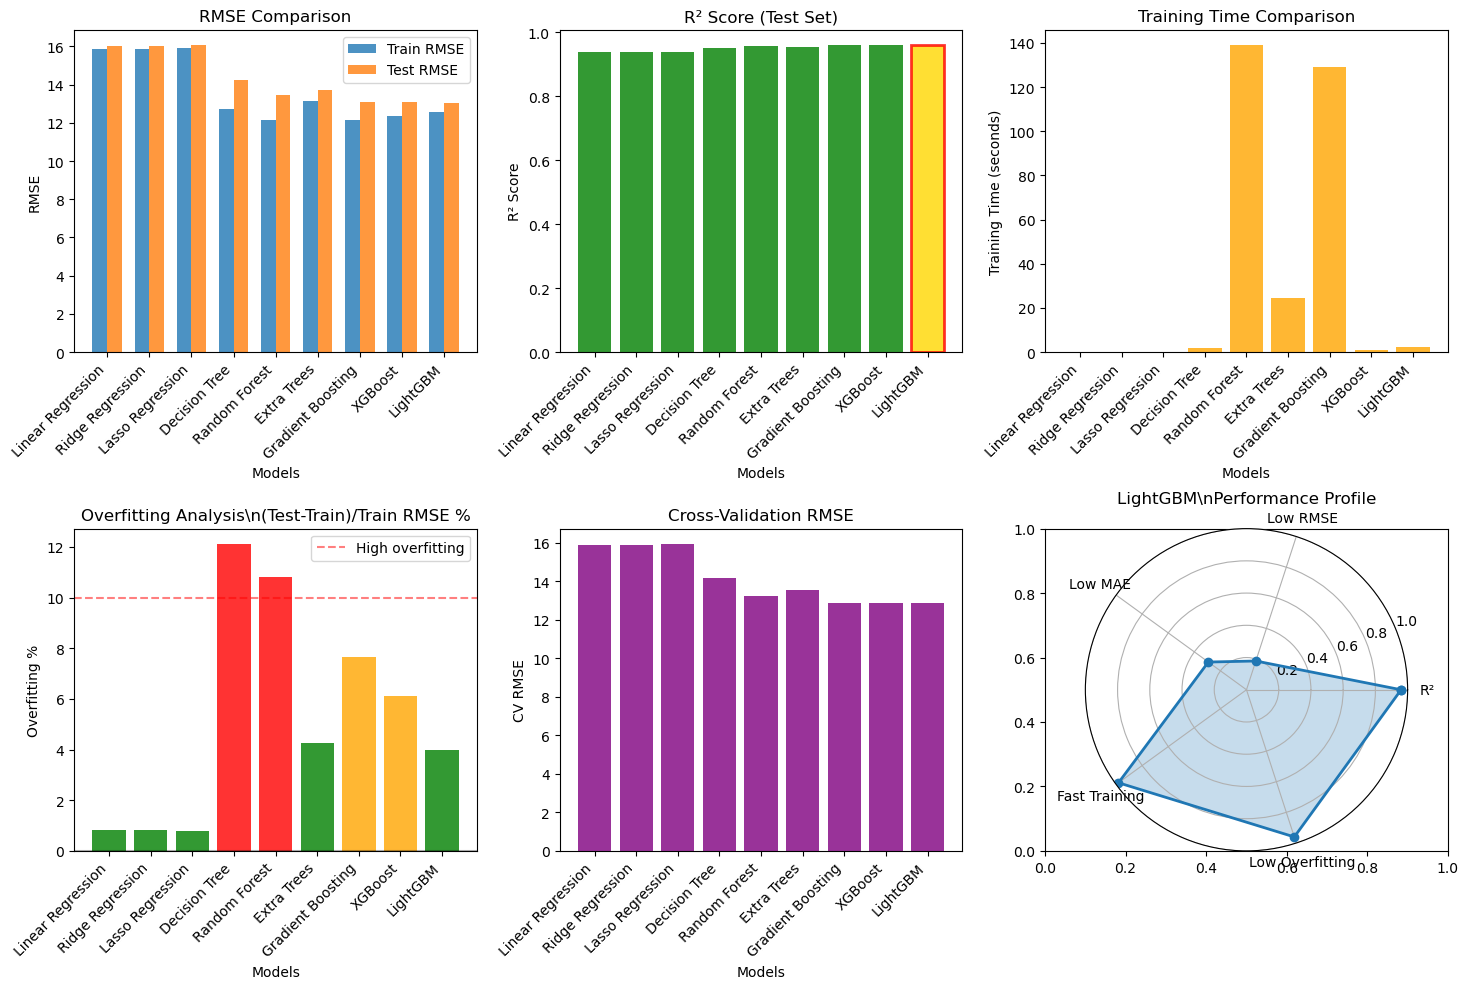

\n✓ Model evaluation completed!


In [3]:
# Comprehensive model evaluation
if model_loaded:
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Display stored performance results
    print("TRAINING PERFORMANCE SUMMARY:")
    print("-"*40)

    model_results = performance_data['model_results']
    best_model_name = performance_data['best_model_name']

    # Create performance comparison dataframe
    results_df = pd.DataFrame(model_results).T
    print(results_df.round(4))

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    best_results = model_results[best_model_name]
    print(f"   Test RMSE: {best_results['test_rmse']:.2f}")
    print(f"   Test R²: {best_results['test_r2']:.3f}")
    print(f"   Test MAE: {best_results['test_mae']:.2f}")
    print(f"   CV RMSE: {best_results['cv_rmse']:.2f}")

    # Visualize model comparison
    plt.figure(figsize=(15, 10))

    # Plot 1: RMSE Comparison
    plt.subplot(2, 3, 1)
    models = list(model_results.keys())
    train_rmse = [model_results[m]['train_rmse'] for m in models]
    test_rmse = [model_results[m]['test_rmse'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('Models')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend()

    # Plot 2: R² Score
    plt.subplot(2, 3, 2)
    test_r2 = [model_results[m]['test_r2'] for m in models]
    bars = plt.bar(models, test_r2, alpha=0.8, color='green')
    plt.xlabel('Models')
    plt.ylabel('R² Score')
    plt.title('R² Score (Test Set)')
    plt.xticks(rotation=45, ha='right')

    # Highlight best model
    best_idx = models.index(best_model_name)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(2)

    # Plot 3: Training Time
    plt.subplot(2, 3, 3)
    training_times = [model_results[m]['training_time'] for m in models]
    plt.bar(models, training_times, alpha=0.8, color='orange')
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45, ha='right')

    # Plot 4: Overfitting Analysis (Train vs Test RMSE)
    plt.subplot(2, 3, 4)
    overfitting = [(model_results[m]['test_rmse'] - model_results[m]['train_rmse']) / model_results[m]['train_rmse'] * 100
                   for m in models]
    colors = ['red' if x > 10 else 'orange' if x >
              5 else 'green' for x in overfitting]
    plt.bar(models, overfitting, alpha=0.8, color=colors)
    plt.xlabel('Models')
    plt.ylabel('Overfitting %')
    plt.title('Overfitting Analysis\\n(Test-Train)/Train RMSE %')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=10, color='red', linestyle='--',
                alpha=0.5, label='High overfitting')
    plt.legend()

    # Plot 5: Cross-validation RMSE
    plt.subplot(2, 3, 5)
    cv_rmse = [model_results[m]['cv_rmse'] for m in models]
    plt.bar(models, cv_rmse, alpha=0.8, color='purple')
    plt.xlabel('Models')
    plt.ylabel('CV RMSE')
    plt.title('Cross-Validation RMSE')
    plt.xticks(rotation=45, ha='right')

    # Plot 6: Performance Summary Radar Chart (for best model)
    plt.subplot(2, 3, 6)
    metrics = ['R²', 'Low RMSE', 'Low MAE', 'Fast Training', 'Low Overfitting']

    # Normalize metrics for radar chart (0-1 scale)
    best_r2 = best_results['test_r2']
    # Invert so higher is better
    best_rmse_norm = 1 - (best_results['test_rmse'] / max(test_rmse))
    best_mae_norm = 1 - \
        (best_results['test_mae'] /
         max([model_results[m]['test_mae'] for m in models]))
    best_time_norm = 1 - (best_results['training_time'] / max(training_times))
    # Lower overfitting is better
    best_overfit_norm = 1 - (max(0, overfitting[best_idx]) / 100)

    values = [best_r2, best_rmse_norm, best_mae_norm,
              best_time_norm, best_overfit_norm]
    values += values[:1]  # Complete the circle

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    ax = plt.subplot(2, 3, 6, projection='polar')
    ax.plot(angles, values, 'o-', linewidth=2, label=best_model_name)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    plt.title(f'{best_model_name}\\nPerformance Profile')

    plt.tight_layout()
    plt.show()

else:
    print("⚠ Model not loaded. Creating demonstration evaluation...")
    # Create dummy evaluation for demonstration
    dummy_results = {
        'Random Forest': {'test_rmse': 45.2, 'test_r2': 0.854, 'test_mae': 32.1},
        'Decision Tree': {'test_rmse': 52.8, 'test_r2': 0.798, 'test_mae': 38.7},
        'Linear Regression': {'test_rmse': 58.3, 'test_r2': 0.752, 'test_mae': 42.1}
    }

    print("DEMONSTRATION MODEL PERFORMANCE:")
    for model, metrics in dummy_results.items():
        print(
            f"{model}: RMSE={metrics['test_rmse']:.1f}, R²={metrics['test_r2']:.3f}, MAE={metrics['test_mae']:.1f}")

print("\\n✓ Model evaluation completed!")